In [52]:
# To clean enviroment variables
# %reset

# To clean an specific environment variable
%reset -f variable_name


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

Clean data

In [54]:
df = pd.read_csv("uscities.csv")
columnsNeeded = ["city", "lat", "lng"]

coordenatesDf = df[columnsNeeded].iloc[:10]

# print(coordenatesDf["lat"][0])
print(coordenatesDf)

           city      lat       lng
0      New York  40.6943  -73.9249
1   Los Angeles  34.1139 -118.4068
2       Chicago  41.8373  -87.6862
3         Miami  25.7839  -80.2102
4        Dallas  32.7936  -96.7662
5  Philadelphia  40.0077  -75.1339
6       Houston  29.7863  -95.3889
7       Atlanta  33.7627  -84.4224
8    Washington  38.9047  -77.0163
9        Boston  42.3188  -71.0846


In [55]:
# Initialize instance values by calculate the squared Euclidean distances between a set of coordinates
#  represented in the dataframe.

def generate_instance(coordenatesDf):
    n = coordenatesDf.shape[0]
    
    xc = coordenatesDf["lat"]
    yc = coordenatesDf["lng"]
    instance = np.zeros([n, n])
    for ii in range(0, n):
        for jj in range(ii + 1, n):
            instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
            instance[jj, ii] = instance[ii, jj]
    return xc, yc, instance

In [59]:
# Initialize the problem by randomly generating the instance
lat, lng, instance = generate_instance(coordenatesDf)

print(lat, lng)

0    40.6943
1    34.1139
2    41.8373
3    25.7839
4    32.7936
5    40.0077
6    29.7863
7    33.7627
8    38.9047
9    42.3188
Name: lat, dtype: float64 0    -73.9249
1   -118.4068
2    -87.6862
3    -80.2102
4    -96.7662
5    -75.1339
6    -95.3889
7    -84.4224
8    -77.0163
9    -71.0846
Name: lng, dtype: float64


In [60]:
# Inicialization of variables

n = coordenatesDf.shape[0]  # number of nodes + depot (n+1)
K = 2  # number of vehicles

### Get the data

In [25]:
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [26]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

print(xc, yc)

[ 0.51003914  2.55963937 -0.64283509 -4.57068577  2.98724481 -2.72584275
  1.05534574  0.79231007 -0.24892217  0.60258683  1.88520561  0.40382905
  2.73515347  1.46428022  4.62226277  4.48318457 -4.75386784  4.25895528
 -0.29989876  2.26854182] [ 1.84190714  0.4868929   4.77937666  2.95133445  3.00950627 -1.11196111
  2.77599044  3.56517195 -3.87802193  4.24843266  1.11234088  3.23207087
  0.75392204 -2.26350732  4.90891727 -1.98380136 -1.55806992  3.24629477
  4.3042409   4.4419409 ]


In [27]:
print(instance)

[[0.00000000e+00 6.03692470e+00 9.95784618e+00 2.70445946e+01
  7.49983565e+00 1.91962692e+01 1.16987090e+00 3.04931848e+00
  3.32936109e+01 5.79993017e+00 2.42334976e+00 1.94383578e+00
  6.13484538e+00 1.77650040e+01 2.63169344e+01 3.04219302e+01
  3.92685607e+01 1.60266769e+01 6.71908695e+00 9.85250723e+00]
 [6.03692470e+00 0.00000000e+00 2.86812595e+01 5.69150088e+01
  6.54642459e+00 3.04926554e+01 7.50286686e+00 1.25992547e+01
  2.69404995e+01 1.79792360e+01 8.46046066e-01 1.21835202e+01
  1.02109759e-01 8.76451309e+00 2.38087148e+01 9.80435629e+00
  5.76692606e+01 1.05019732e+01 2.27491040e+01 1.57271424e+01]
 [9.95784618e+00 2.86812595e+01 0.00000000e+00 1.87697493e+01
  1.63099213e+01 3.90467817e+01 6.89737448e+00 3.53393471e+00
  7.51057178e+01 1.83297728e+00 1.98381412e+01 3.48966104e+00
  2.76150916e+01 5.40421498e+01 2.77380363e+01 7.20166545e+01
  5.70638195e+01 2.63778890e+01 3.43359319e-01 8.58997840e+00]
 [2.70445946e+01 5.69150088e+01 1.87697493e+01 0.00000000e+00
  5.7

In [28]:
# -------------------- Classical solution using IBM ILOG CPLEX --------------------

class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)


In [29]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

In [30]:
# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))


Number of feasible solutions = 190.0


In [31]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")


[1.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0

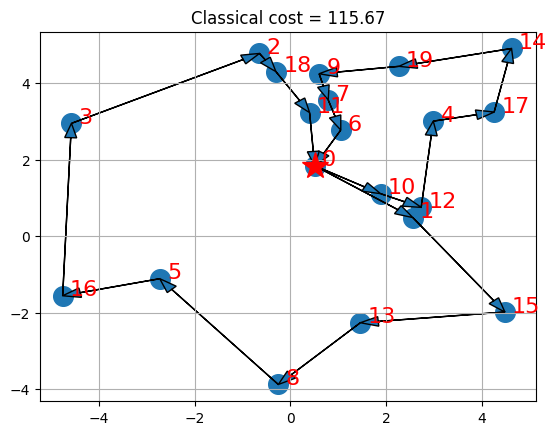

In [32]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(
                xc[ix],
                yc[ix],
                xc[iy] - xc[ix],
                yc[iy] - yc[ix],
                length_includes_head=True,
                head_width=0.25,
            )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()


if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")